<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Positional_Trading_with_Auto_Regression_Finite_Horizon_Forecast_(Linear_Algebra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'BANKBEES.NS'

ar_p = 300
ar_h = 260

num_paths = 10000
paths_to_plot = 5

In [4]:
def download_data(entity, ticker):
    print(f"Downloading {ticker}")

    data = yf.download(ticker, period="5y", interval="1d")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [5]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = data['log_S'].diff()

In [6]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

In [7]:
def feature_engg(entity):
    data = entity['train']

    features_df = data[['S', 'r']]
    features_df.eval('x = (r - r.mean())/r.std()', inplace = True)

    features_df['x'] = (features_df['r'] - features_df['r'].mean())/features_df['r'].std()

    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)


    features_df.dropna(inplace = True)

    entity['features'] = features_df

    entity['features_train_x'] = entity['features'][[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_train_y'] = entity['features'][[f'x_p{idx}' for idx in range(ar_h)]]

In [8]:
def fit_model(entity):
    A = np.matmul(entity['features_train_x'].T, entity['features_train_x'])
    b = np.matmul(entity['features_train_x'].T, entity['features_train_y'])
    inv_A = pd.DataFrame(la.inv(A), columns = A.columns, index = A.index)
    entity['weights'] = np.matmul(inv_A, b)

    mean_x = pd.DataFrame({'Intercept' : entity['features_train_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept' : entity['features_train_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, entity['weights'])

    entity['intercept'] = intercept
    entity['residue'] = entity['features_train_y'] - np.matmul(entity['features_train_x'], entity['weights'])

    dof = len(entity['features_train_x']) - len(entity['weights'])
    sigma_df = pd.DataFrame({'sigma' : np.sqrt((entity['residue']**2).sum()/dof)})

    entity['params'] = pd.concat([intercept, entity['weights'], sigma_df.T])

In [9]:
def test_forecast(entity):
    mean = np.matmul(entity['features_train_x'].iloc[-1:], entity['params'].iloc[1 :-1]) + entity['params'].iloc[0]
    sigma = entity['params'].iloc[-1:]

    entity['test_forecast_x'] = pd.DataFrame(
        data = np.random.normal(loc = mean, scale = sigma, size = (num_paths, ar_h)),
        columns = entity['features_train_y'].columns
    )

    entity['test_forecast'] = entity['test_forecast_x'] * entity['train']['r'].std() + entity['train']['r'].mean()
    entity['test_forecast'].columns = entity['test'].index
    entity['test_forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['test_forecast'] = entity['test_forecast'].T

    init_S_df = entity['train'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['test_forecast'].iloc[:1]), columns = entity['test_forecast'].columns, index = init_S_df.index)
    entity['test_forecast'] = pd.concat([init_forecast_df, entity['test_forecast']])
    entity['test_forecast_price'] = init_S_df.iloc[0, 0] * entity['test_forecast'].cumsum().apply(np.exp)

    entity['test_monte_carlo_quantiles'] = entity['test_forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['test_monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [10]:
def forecast(entity):
    forecast_input_df = pd.DataFrame({'x' : (entity['data'].iloc[-(ar_p + 1):]['r'] - entity['train']['r'].mean())/entity['train']['r'].std()})

    for idx in range(ar_p):
        forecast_input_df[f'x_m{idx + 1}'] = forecast_input_df['x'].shift(idx + 1)

    forecast_input_df.drop('x', axis = 1, inplace = True)
    forecast_input_df.dropna(inplace = True)

    mean = np.matmul(forecast_input_df, entity['params'].iloc[1 :-1]) + entity['params'].iloc[0]
    sigma = entity['params'].iloc[-1:]

    entity['forecast_x'] = pd.DataFrame(
        data = np.random.normal(loc = mean, scale = sigma, size = (num_paths, ar_h)),
        columns = entity['features_train_y'].columns
    )

    entity['forecast'] = entity['forecast_x'] * entity['train']['r'].std() + entity['train']['r'].mean()
    entity['forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['forecast'] = entity['forecast'].T

    init_S_df = entity['data'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['forecast'].iloc[:1]), columns = entity['forecast'].columns, index = init_S_df.index)
    entity['forecast'] = pd.concat([init_forecast_df, entity['forecast']])

    entity['forecast'].index = pd.date_range(start=init_S_df.index[0], periods = len(entity['forecast']), freq='B')
    entity['forecast_price'] = init_S_df.iloc[0, 0] * entity['forecast'].cumsum().apply(np.exp)

    entity['monte_carlo_quantiles'] = entity['forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [11]:
def plot_test(entity):
    selected_paths = np.random.choice(entity['test_forecast_price'].columns, paths_to_plot, replace=False)

    plt.rcParams.update({
        "font.size": 14,  # General font size
        "axes.labelsize": 16,  # X and Y axis labels
        "xtick.labelsize": 12,  # X-axis tick labels
        "ytick.labelsize": 12,  # Y-axis tick labels
        "legend.fontsize": 14  # Legend text size
    })

    plt.figure(figsize=(15, 10))
    sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-(ar_p + ar_h):].reset_index(), color = 'black')

    for p in selected_paths:
        sns.lineplot(x = 'Date', y = p, data = entity['test_forecast_price'].reset_index())

    plt.fill_between(entity['test_monte_carlo_quantiles'].index, entity['test_monte_carlo_quantiles']['low_ci'], entity['test_monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
    plt.axhline(entity['test_monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
    plt.axhline(entity['test_monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
    plt.axvline(entity['test_monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Test for {ticker}')
    _ = plt.xticks(rotation=90)

    plt.savefig(f"test_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()  # Close the figure to avoid overlap

In [12]:
def plot_forecast(entity):
    selected_paths = np.random.choice(entity['forecast_price'].columns, paths_to_plot, replace=False)

    plt.rcParams.update({
        "font.size": 14,  # General font size
        "axes.labelsize": 16,  # X and Y axis labels
        "xtick.labelsize": 12,  # X-axis tick labels
        "ytick.labelsize": 12,  # Y-axis tick labels
        "legend.fontsize": 14  # Legend text size
    })

    plt.figure(figsize=(15, 10))
    sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-ar_p:].reset_index(), color = 'black')

    for p in selected_paths:
        sns.lineplot(x = 'index', y = p, data = entity['forecast_price'].reset_index())

    plt.fill_between(entity['monte_carlo_quantiles'].index, entity['monte_carlo_quantiles']['low_ci'], entity['monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
    plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
    plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
    plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Forecast for {ticker}')
    _ = plt.xticks(rotation=90)

    plt.savefig(f"forecast_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()  # Close the figure to avoid overlap

In [13]:
def display_result(entity):
    print('Long Risk Level for ' , str(entity['monte_carlo_quantiles'].index[-1]), ' is ', entity['monte_carlo_quantiles']['low_ci'].min(),
          'estimated on ', str(entity['monte_carlo_quantiles'].index[0]))

    print('Short Risk Level for ' , str(entity['monte_carlo_quantiles'].index[-1]), ' is ', entity['test_monte_carlo_quantiles']['high_ci'].max(),
          'estimated on ', str(entity['monte_carlo_quantiles'].index[0]))

    print('Current Price on ', str(entity['data'].index[-1]), ' is ', entity['data'].iloc[-1]['S'])

In [14]:
def main(ticker):
    entity = {}
    download_data(entity, ticker)
    calculate_return(entity)
    split_data(entity)
    feature_engg(entity)
    fit_model(entity)
    test_forecast(entity)
    forecast(entity)
    plot_test(entity)
    plot_forecast(entity)
    display_result(entity)
    display(entity['params'])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


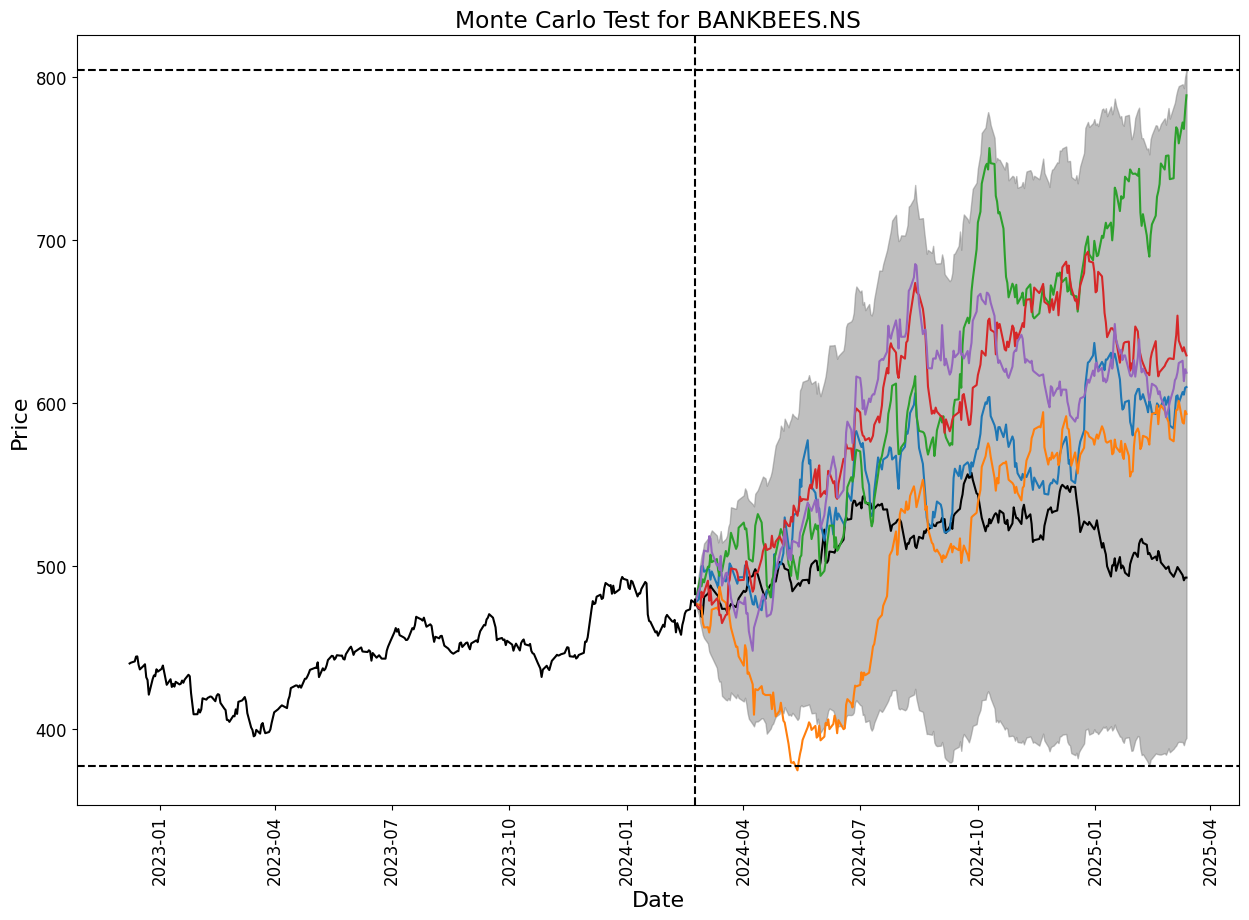

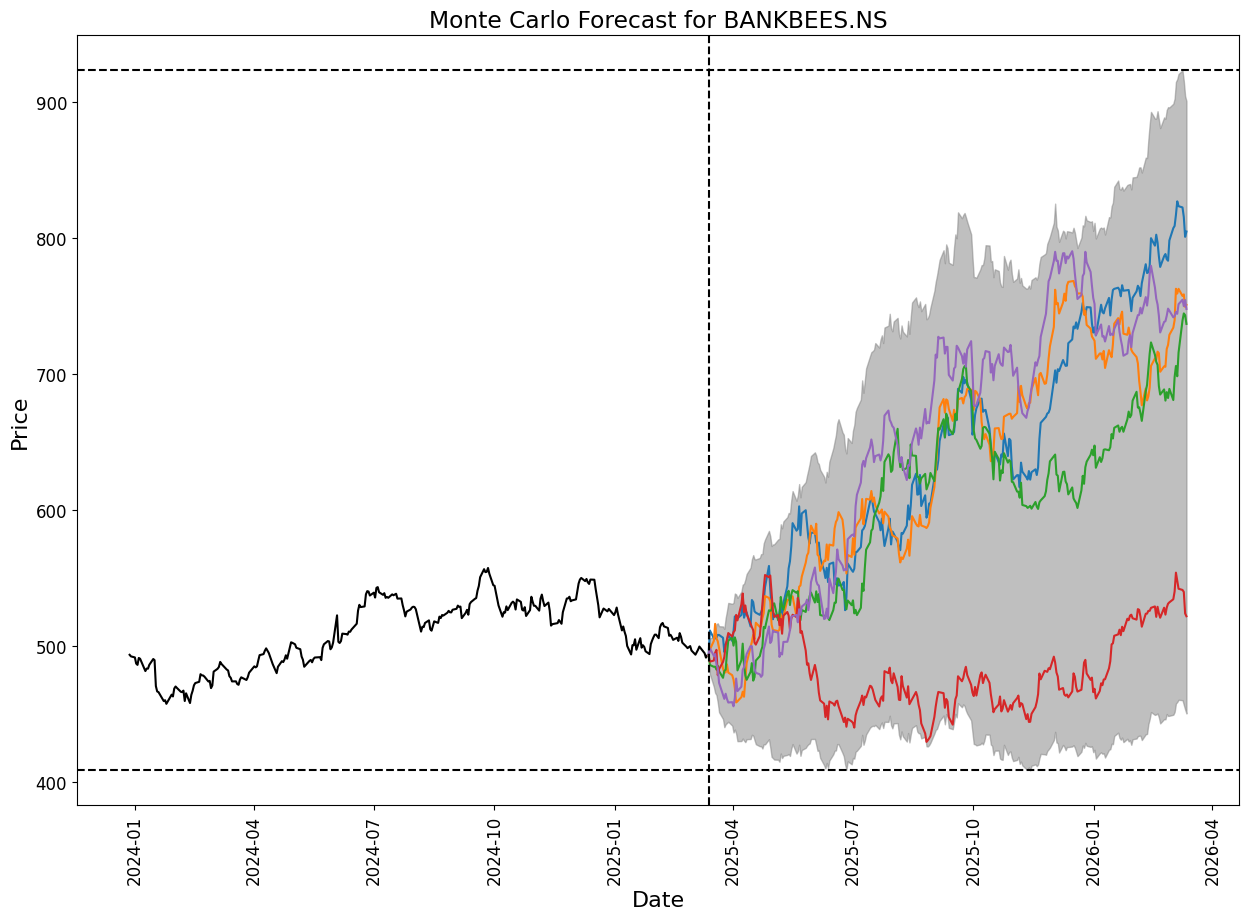

Long Risk Level for  2026-03-12 05:30:00+05:30  is  408.4927747430591 estimated on  2025-03-13 05:30:00+05:30
Short Risk Level for  2026-03-12 05:30:00+05:30  is  804.3719328668448 estimated on  2025-03-13 05:30:00+05:30
Current Price on  2025-03-13 05:30:00+05:30  is  493.17999267578125


,x_p0,x_p1,x_p2,x_p3,x_p4,x_p5,x_p6,x_p7,x_p8,x_p9,...,x_p250,x_p251,x_p252,x_p253,x_p254,x_p255,x_p256,x_p257,x_p258,x_p259
Intercept,-0.015110,-0.014700,-0.015191,-0.015913,-0.014151,-0.017065,-0.017431,-0.009164,-0.012882,-0.010950,...,-0.003197,-0.003556,0.001347,0.003027,0.005299,0.005532,0.009637,0.012583,0.011729,0.006929
x_m1,0.142113,0.017454,0.068845,0.080159,0.079182,0.027564,-0.126889,0.010084,-0.016189,-0.118772,...,0.071951,-0.068632,0.106257,-0.046771,0.076904,0.015472,-0.093239,0.026027,-0.034037,-0.056695
x_m2,-0.015044,0.066286,0.072224,0.056982,0.020808,-0.132739,0.019588,-0.003807,-0.108473,0.086195,...,-0.074274,0.108498,-0.065824,0.075854,0.000145,-0.094584,0.037742,-0.044144,-0.045168,-0.013351
x_m3,0.072830,0.071261,0.057197,0.028194,-0.132859,0.023304,-0.000855,-0.114477,0.081194,0.022708,...,0.106903,-0.061566,0.078495,0.002849,-0.090488,0.040374,-0.042598,-0.038533,-0.018658,0.060224
x_m4,0.057245,0.056588,0.024808,-0.142803,0.017576,-0.006023,-0.103052,0.084613,0.032328,-0.079432,...,-0.062332,0.082269,-0.002435,-0.089947,0.033009,-0.039555,-0.032493,-0.028080,0.061333,0.042236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x_m297,-0.001312,-0.002089,0.059416,0.015059,-0.073750,-0.018959,-0.008349,-0.035195,0.022377,0.041060,...,0.003356,-0.043048,0.044887,-0.046985,-0.023727,-0.007530,-0.072784,-0.051500,-0.017552,0.007822
x_m298,-0.003758,0.055844,0.015539,-0.068464,-0.017969,-0.001810,-0.028239,0.020670,0.039696,-0.066071,...,-0.043773,0.052473,-0.046558,-0.023212,-0.004028,-0.061840,-0.044422,-0.009171,-0.000726,0.010028
x_m299,0.055568,0.014493,-0.066883,-0.015834,-0.002490,-0.027529,0.028950,0.038737,-0.060479,0.083377,...,0.055572,-0.041727,-0.018766,-0.004430,-0.060243,-0.034627,-0.006130,-0.002246,0.001903,0.054550
x_m300,0.004992,-0.073542,-0.022007,0.001391,-0.027838,0.041168,0.042066,-0.063527,0.067264,-0.021838,...,-0.054619,-0.008759,-0.019015,-0.055289,-0.033846,-0.004817,0.011675,0.024034,0.055277,0.033667


In [15]:
if __name__ == '__main__':
    main(ticker)